In [35]:
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [36]:
import numpy as np

from matplotlib import pyplot as plt

from utils import configs, fitting

import importlib
importlib.reload(configs)
importlib.reload(fitting)

configs.set_plot_configs()

In [37]:
data_file = 'preliminary_measurements.txt'

def read_pendulum_data(data_file):
    l = []
    T = []
    Terr = []

    with open(data_file,'r') as f:
        for line in f.readlines():
            line_data = line.split()
            
            l.append(float(line_data[0]))
            T.append(float(line_data[1])/10)

    return {'l': np.array(l), 'T': np.array(T)}

data = read_pendulum_data(data_file)

In [38]:
class PendulumFitter(fitting.BaseFitter):
    def __init__(self,data):
        x = data['l']
        y = (data['T']/2/np.pi)**2
        yerr = 2 * (0.025/data['T']) * y

        super().__init__(x,y,yerr)

    def _get_initial_guess(self):
        # kappa, l0, g
        return [1, 0.055, 9.81]
    
    def _get_model(self,params):
        kappa, l0, g = params
        return kappa/(l0 + self.x) + (l0 + self.x)/g
    
pendulum_fitter = PendulumFitter(data)
fitting_result = pendulum_fitter.fit()

In [39]:
fitting_result

{'params': array([9.67502195e-04, 3.81657707e-02, 9.78088810e+00]),
 'e_params': array([0.00760758, 0.19882599, 1.20015623]),
 'chisqr': 3.154344442166229,
 'cov': array([[ 5.78752503e-05, -1.49769440e-03, -8.81104515e-03],
        [-1.49769440e-03,  3.95317737e-02,  2.36522941e-01],
        [-8.81104515e-03,  2.36522941e-01,  1.44037498e+00]]),
 'success': True,
 'message': '`ftol` termination condition is satisfied.'}

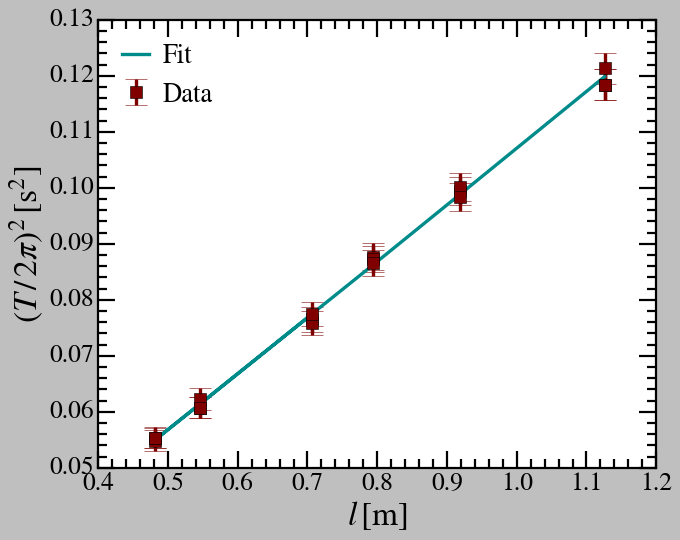

In [55]:
fig, ax = plt.subplots(figsize=(9,7))

ax.errorbar(data['l'], (data['T']/2/np.pi)**2, 
            yerr=2 * (0.025/data['T']) * (data['T']/2/np.pi)**2, 
            fmt=' s', markersize=10,elinewidth=3,capsize=10,
            color='maroon',label='Data')

ax.plot(data['l'], pendulum_fitter._get_model(fitting_result['params']),
        color='darkcyan',label='Fit')

ax.set_xlabel(r'$l\,[$m$]$')
ax.set_ylabel(r'$\left(T \, / \, 2\pi\right)^2 \, [$s$^2]$')

ax.legend(loc='upper left', ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5, fontsize=24)